<a href="https://colab.research.google.com/github/Sha-ziya/predict/blob/main/cloudpred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas numpy scikit-learn xgboost matplotlib seaborn tensorflow keras

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime, timedelta
import random

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Function to generate synthetic cloud server data
def generate_synthetic_data(num_samples=10000):
    np.random.seed(42)
    data = {
        'timestamp': pd.to_datetime(pd.date_range(start='2023-01-01', periods=num_samples, freq='5min')),
        'server_id': [f'server_{i % 10}' for i in range(num_samples)], # 10 servers
        'cpu_usage': np.random.uniform(10, 90, num_samples),
        'memory_usage': np.random.uniform(20, 80, num_samples),
        'disk_io': np.random.uniform(0, 100, num_samples),
        'network_in': np.random.randint(100, 1000, num_samples),
        'network_out': np.random.randint(100, 1000, num_samples),
        'temperature': np.random.uniform(30, 80, num_samples),
        'disk_space': np.random.uniform(0, 100, num_samples),
        'current_cost': np.random.uniform(0.05, 0.25, num_samples),
        'failure': np.random.choice([0, 1], num_samples, p=[0.998, 0.002]) # Simulate rare failures
    }

    df = pd.DataFrame(data)

    # Simulate some correlations and patterns (optional, for more realistic data)
    df['temperature'] = df['temperature'] + df['cpu_usage'] * 0.2
    df['disk_space'] = df['disk_space'] - df['disk_io'] * 0.5

    # Simulate optimal CPU based on load (example)
    df['optimal_cpu'] = df['cpu_usage'] * np.random.uniform(0.8, 1.2, num_samples) # Simple simulation


    return df

In [ ]:
cloud_data = generate_synthetic_data(10000000)
cloud_data.head()

,timestamp,server_id,cpu_usage,memory_usage,disk_io,network_in,network_out,temperature,disk_space,current_cost,failure,optimal_cpu,hour,is_business_hours
0,2023-01-01 00:00:00,server_0,60.040095,47.533182,0.000000,498,506,67.459458,49.676830,0.050550,0,60.040095,0,0
1,2023-01-01 00:05:00,server_1,28.779467,47.555495,0.000000,515,525,55.956545,54.209726,0.151165,0,43.169201,0,0
2,2023-01-01 00:10:00,server_2,53.138150,82.390484,63.671283,467,482,67.487684,63.223747,0.057810,0,53.138150,0,0
3,2023-01-01 00:15:00,server_3,26.490595,82.885755,1.904575,527,503,64.946174,79.790462,0.195144,0,39.735892,0,0
4,2023-01-01 00:20:00,server_4,44.008618,63.087259,54.476097,512,494,54.418924,67.101230,0.145810,0,44.008618,0,0


In [ ]:
print(cloud_data.describe())

                           timestamp     cpu_usage  memory_usage  \
count                       10000000  1.000000e+07  1.000000e+07   
mean   2070-07-14 02:37:30.000019968  4.999812e+01  5.998549e+01   
min              2023-01-01 00:00:00  0.000000e+00  0.000000e+00   
25%              2046-10-07 13:18:45  3.650060e+01  4.988653e+01   
50%              2070-07-14 02:37:30  4.999965e+01  6.000857e+01   
75%              2094-04-19 15:56:15  6.348777e+01  7.012194e+01   
max              2118-01-25 05:15:00  1.000000e+02  1.000000e+02   
std                              NaN  1.977524e+01  1.494868e+01   

            disk_io    network_in   network_out   temperature    disk_space  \
count  1.000000e+07  1.000000e+07  1.000000e+07  1.000000e+07  1.000000e+07   
mean   4.050678e+01  4.999921e+02  4.999907e+02  6.497942e+01  6.987118e+01   
min    0.000000e+00  3.920000e+02  3.890000e+02  3.000000e+01  0.000000e+00   
25%    2.312092e+01  4.850000e+02  4.850000e+02  5.825233e+01  5.987712

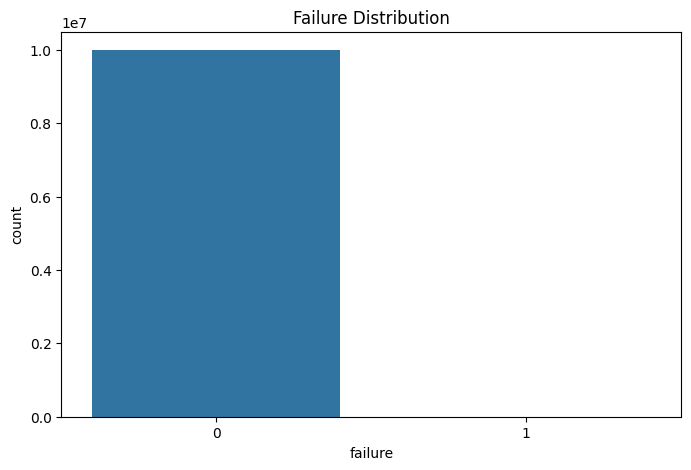

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x='failure', data=cloud_data)
plt.title('Failure Distribution')
plt.show()

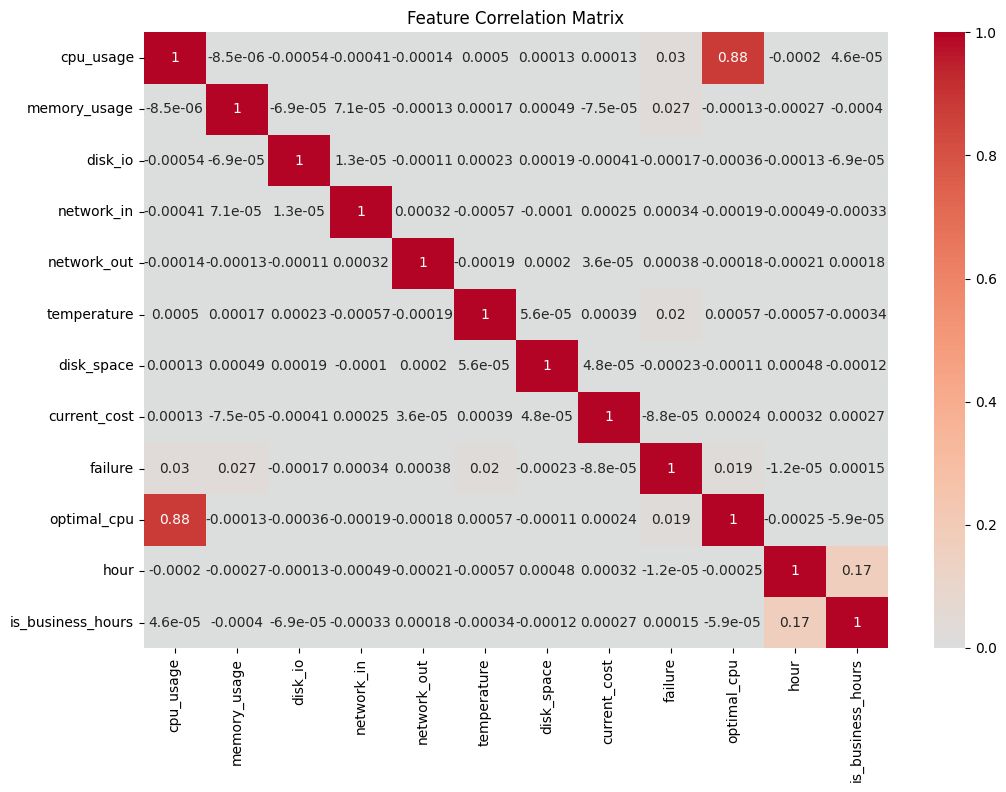

In [ ]:
plt.figure(figsize=(12, 8))
# Exclude non-numeric columns before calculating correlation
corr = cloud_data.drop(['server_id', 'timestamp'], axis=1).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

In [ ]:
# First, import all required libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import joblib

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

# Now define the data generation function
def generate_synthetic_data(num_samples=10000):
    # Generate timestamps
    start_time = datetime(2023, 1, 1)
    timestamps = [start_time + timedelta(minutes=5*i) for i in range(num_samples)]

    # Generate server IDs
    server_ids = [f"server_{i%10}" for i in range(num_samples)]

    # Generate metrics with some correlations
    data = {
        'timestamp': timestamps,
        'server_id': server_ids,
        'cpu_usage': np.random.normal(50, 20, num_samples).clip(0, 100),
        'memory_usage': np.random.normal(60, 15, num_samples).clip(0, 100),
        'disk_io': np.random.normal(40, 25, num_samples).clip(0, 100),
        'network_in': np.random.poisson(500, num_samples),
        'network_out': np.random.poisson(500, num_samples),
        'temperature': np.random.normal(65, 10, num_samples).clip(30, 90),
        'disk_space': 100 - np.random.normal(30, 15, num_samples).clip(0, 100),
        'current_cost': np.random.uniform(0.05, 0.20, num_samples)
    }

    # Create some failure patterns
    df = pd.DataFrame(data)

    # Failure conditions (synthetic rules)
    failure_conditions = (
        (df['cpu_usage'] > 90) &
        (df['memory_usage'] > 85) &
        (df['temperature'] > 75)
    ) | (
        (df['disk_io'] > 95) &
        (df['disk_space'] < 10)
    )

    df['failure'] = failure_conditions.astype(int)

    # Add some cost optimization features
    df['optimal_cpu'] = np.where(
        df['cpu_usage'] < 30,
        df['cpu_usage'] * 1.5,  # can handle more load
        np.where(
            df['cpu_usage'] > 70,
            df['cpu_usage'] * 0.7,  # should scale down
            df['cpu_usage']  # no change
        )
    )

    # Add time-based patterns (more load during business hours)
    df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
    df['is_business_hours'] = ((df['hour'] >= 9) & (df['hour'] <= 17)).astype(int)

    return df

# Generate the dataset
cloud_data = generate_synthetic_data(10000)

# Now define the preprocessing function
def preprocess_data(df):
    # Extract time features
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

    # Lag features for time series analysis
    for lag in [1, 2, 3]:
        df[f'cpu_lag_{lag}'] = df.groupby('server_id')['cpu_usage'].shift(lag)
        df[f'memory_lag_{lag}'] = df.groupby('server_id')['memory_usage'].shift(lag)

    # Rolling statistics
    df['cpu_rolling_avg_3'] = df.groupby('server_id')['cpu_usage'].transform(
        lambda x: x.rolling(3, min_periods=1).mean()
    )

    # Drop rows with NA (from lag features)
    df = df.dropna()

    return df

# Now preprocess the data
processed_data = preprocess_data(cloud_data.copy())

# Show the first few rows to verify
processed_data.head()

,timestamp,server_id,cpu_usage,memory_usage,disk_io,network_in,network_out,temperature,disk_space,current_cost,...,is_business_hours,day_of_week,is_weekend,cpu_lag_1,memory_lag_1,cpu_lag_2,memory_lag_2,cpu_lag_3,memory_lag_3,cpu_rolling_avg_3
30,2023-01-01 02:30:00,server_0,37.965868,72.351348,29.494023,501,488,58.308117,75.381830,0.112121,...,0,6,1,79.312975,83.172622,40.731646,73.829046,59.934283,49.822579,52.670163
31,2023-01-01 02:35:00,server_1,87.045564,74.184501,69.647706,490,487,73.783644,72.292622,0.075268,...,0,6,1,45.484474,69.061461,40.685405,72.771149,47.234714,55.417508,57.738481
32,2023-01-01 02:40:00,server_2,49.730056,67.565476,7.200961,481,491,70.586728,77.649243,0.067728,...,0,6,1,51.350564,80.415101,54.839245,40.263039,62.953771,51.039284,51.973288
33,2023-01-01 02:45:00,server_3,28.845781,51.880514,51.661742,450,536,45.515290,57.910582,0.067059,...,0,6,1,21.505036,60.971870,11.734395,53.010735,80.460597,61.656271,20.695071
34,2023-01-01 02:50:00,server_4,66.450898,30.347676,58.205953,514,483,71.575962,62.368189,0.050052,...,0,6,1,39.112346,71.481562,15.501643,72.344829,45.316933,77.957678,40.354962


In [ ]:
features = [
    'cpu_usage', 'memory_usage', 'disk_io', 'network_in', 'network_out',
    'temperature', 'disk_space', 'hour', 'is_business_hours', 'day_of_week',
    'is_weekend', 'cpu_lag_1', 'cpu_lag_2', 'memory_lag_1', 'cpu_rolling_avg_3'
]

target = 'failure'


In [ ]:
# Split data
X = processed_data[features]
y = processed_data[target]

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Evaluate
y_pred_rf = rf_model.predict(X_test_scaled)
print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1994

    accuracy                           1.00      1994
   macro avg       1.00      1.00      1.00      1994
weighted avg       1.00      1.00      1.00      1994

Confusion Matrix:
[[1994]]


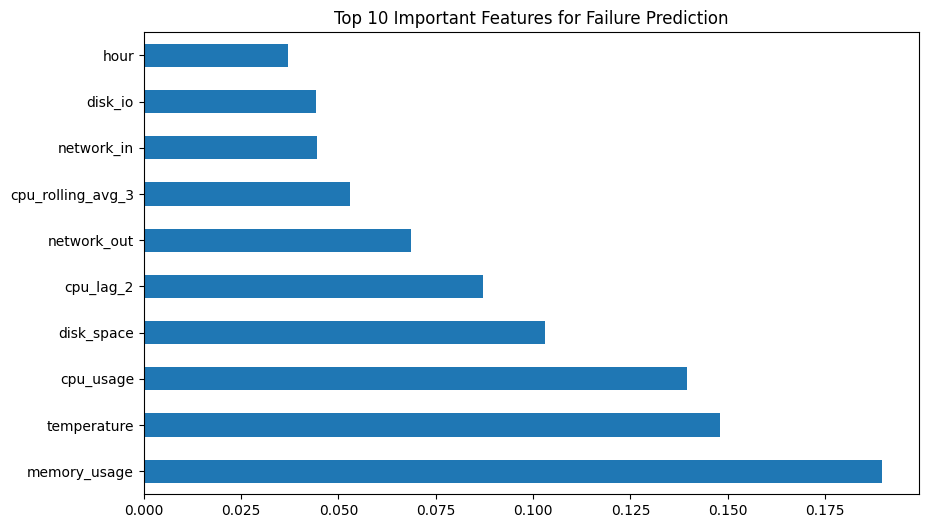

In [ ]:
# Feature Importance
plt.figure(figsize=(10, 6))
feat_importances = pd.Series(rf_model.feature_importances_, index=features)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Important Features for Failure Prediction')
plt.show()


In [ ]:
# XGBoost Classifier
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    scale_pos_weight=np.sum(y_train == 0) / np.sum(y_train == 1)  # handle class imbalance
)
xgb_model.fit(X_train_scaled, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Evaluate
y_pred_xgb = xgb_model.predict(X_test_scaled)
print("XGBoost Performance:")
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

XGBoost Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1994

    accuracy                           1.00      1994
   macro avg       1.00      1.00      1.00      1994
weighted avg       1.00      1.00      1.00      1994

Confusion Matrix:
[[1994]]


Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8845 - loss: 0.3475 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0083 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9994 - loss: 0.0127 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0017 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9994 - loss: 0.0087 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 7.1662e-04 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9994 - loss: 0.0061 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 4.3503e-04 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9994 - loss: 0.0069 -

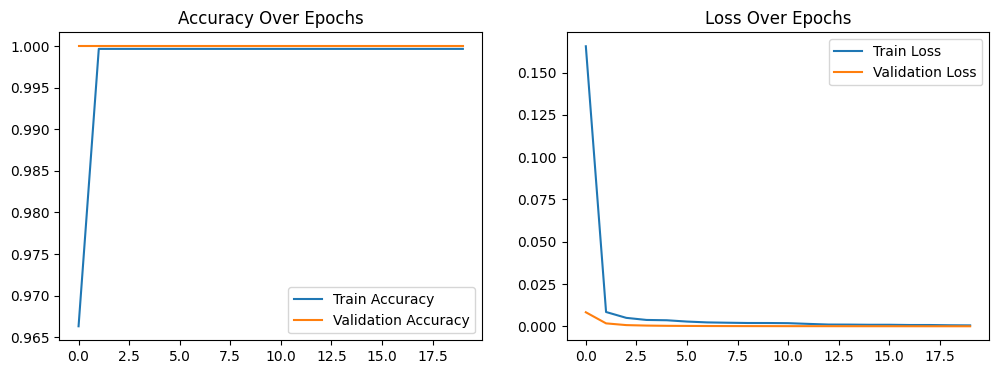

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Neural Network Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1994

    accuracy                           1.00      1994
   macro avg       1.00      1.00      1.00      1994
weighted avg       1.00      1.00      1.00      1994

Confusion Matrix:
[[1994]]


In [ ]:
# First, ensure all required imports are present
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Prepare the data (assuming we have processed_data from earlier steps)
features = [
    'cpu_usage', 'memory_usage', 'disk_io', 'network_in', 'network_out',
    'temperature', 'disk_space', 'hour', 'is_business_hours', 'day_of_week',
    'is_weekend', 'cpu_lag_1', 'cpu_lag_2', 'memory_lag_1', 'cpu_rolling_avg_3'
]
target = 'failure'

X = processed_data[features]
y = processed_data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Now define and train the neural network
def build_nn_model(input_shape):
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=input_shape),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
    )

    return model

# Build and train the model
nn_model = build_nn_model((X_train_scaled.shape[1],))
history = nn_model.fit(
    X_train_scaled, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

# Evaluate the model
y_pred_nn = (nn_model.predict(X_test_scaled) > 0.5).astype(int)
print("Neural Network Performance:")
print(classification_report(y_test, y_pred_nn))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nn))

In [ ]:
# Feature engineering for cost optimization
processed_data['cost_category'] = pd.cut(
    processed_data['current_cost'],
    bins=[0, 0.10, 0.15, 0.20],
    labels=['low', 'medium', 'high']
)


In [ ]:
# We'll predict cost categories to identify optimization opportunities
cost_features = [
    'cpu_usage', 'memory_usage', 'disk_io', 'network_in', 'network_out',
    'hour', 'is_business_hours', 'day_of_week', 'is_weekend',
    'cpu_rolling_avg_3'
]

cost_target = 'cost_category'

X_cost = processed_data[cost_features]
y_cost = processed_data[cost_target]

In [ ]:
# Train-test split
X_cost_train, X_cost_test, y_cost_train, y_cost_test = train_test_split(
    X_cost, y_cost, test_size=0.2, random_state=42, stratify=y_cost
)

# Scale features
cost_scaler = StandardScaler()
X_cost_train_scaled = cost_scaler.fit_transform(X_cost_train)
X_cost_test_scaled = cost_scaler.transform(X_cost_test)

Cost Category Prediction Performance:
              precision    recall  f1-score   support

        high       0.34      0.41      0.37       676
         low       0.33      0.33      0.33       670
      medium       0.32      0.25      0.28       648

    accuracy                           0.33      1994
   macro avg       0.33      0.33      0.32      1994
weighted avg       0.33      0.33      0.32      1994



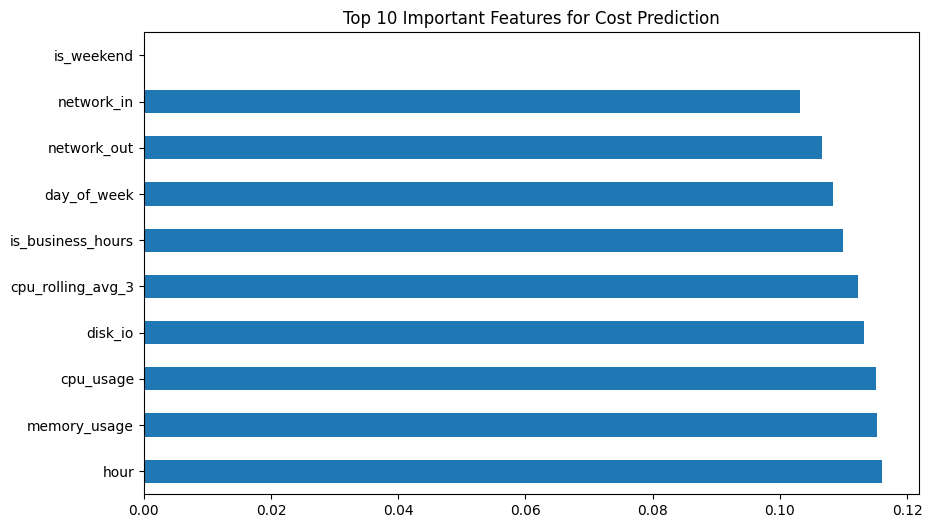


Class Label Mapping:
0 -> high
1 -> low
2 -> medium


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Feature engineering for cost optimization
processed_data['cost_category'] = pd.cut(
    processed_data['current_cost'],
    bins=[0, 0.10, 0.15, 0.20],
    labels=['low', 'medium', 'high']
)

# Encode the string labels to numerical values
label_encoder = LabelEncoder()
processed_data['cost_category_encoded'] = label_encoder.fit_transform(processed_data['cost_category'])

# Select features and target
cost_features = [
    'cpu_usage', 'memory_usage', 'disk_io', 'network_in', 'network_out',
    'hour', 'is_business_hours', 'day_of_week', 'is_weekend',
    'cpu_rolling_avg_3'
]

cost_target = 'cost_category_encoded'  # Now using the encoded version

X_cost = processed_data[cost_features]
y_cost = processed_data[cost_target]

# Train-test split
X_cost_train, X_cost_test, y_cost_train, y_cost_test = train_test_split(
    X_cost, y_cost, test_size=0.2, random_state=42, stratify=y_cost
)

# Scale features
cost_scaler = StandardScaler()
X_cost_train_scaled = cost_scaler.fit_transform(X_cost_train)
X_cost_test_scaled = cost_scaler.transform(X_cost_test)

# Cost category prediction model
cost_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    objective='multi:softmax',  # For multi-class classification
    num_class=3  # Number of cost categories
)
cost_model.fit(X_cost_train_scaled, y_cost_train)

# Evaluate
y_cost_pred = cost_model.predict(X_cost_test_scaled)

# Convert numerical predictions back to original labels for reporting
y_cost_test_labels = label_encoder.inverse_transform(y_cost_test)
y_cost_pred_labels = label_encoder.inverse_transform(y_cost_pred)

print("Cost Category Prediction Performance:")
print(classification_report(y_cost_test_labels, y_cost_pred_labels))

# Feature Importance
plt.figure(figsize=(10, 6))
cost_feat_importances = pd.Series(cost_model.feature_importances_, index=cost_features)
cost_feat_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Important Features for Cost Prediction')
plt.show()

# Show class mapping
print("\nClass Label Mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{i} -> {class_name}")

In [ ]:
# Resource Optimization Recommendation Engine
def recommend_optimization(row):
    """Generate optimization recommendations based on metrics"""
    recommendations = []

    if row['cpu_usage'] < 30:
        recommendations.append("Reduce CPU allocation by 30%")
    elif row['cpu_usage'] > 70:
        recommendations.append("Increase CPU allocation by 30%")

    if row['memory_usage'] < 30:
        recommendations.append("Reduce memory allocation by 30%")
    elif row['memory_usage'] > 70:
        recommendations.append("Increase memory allocation by 30%")

    if row['disk_io'] > 80 and row['disk_space'] < 20:
        recommendations.append("Add additional disk storage")

    if row['temperature'] > 75:
        recommendations.append("Check cooling system or reduce load")

    if not recommendations:
        return "Current configuration appears optimal"

    return "; ".join(recommendations)


In [ ]:
# First, let's modify the recommendation function to handle missing columns safely
def recommend_optimization(row):
    """Generate optimization recommendations based on metrics"""
    recommendations = []

    # CPU recommendation
    if 'cpu_usage' in row and row['cpu_usage'] < 30:
        recommendations.append("Reduce CPU allocation by 30%")
    elif 'cpu_usage' in row and row['cpu_usage'] > 70:
        recommendations.append("Increase CPU allocation by 30%")

    # Memory recommendation
    if 'memory_usage' in row and row['memory_usage'] < 30:
        recommendations.append("Reduce memory allocation by 30%")
    elif 'memory_usage' in row and row['memory_usage'] > 70:
        recommendations.append("Increase memory allocation by 30%")

    # Disk recommendation
    if 'disk_io' in row and 'disk_space' in row:
        if row['disk_io'] > 80 and row['disk_space'] < 20:
            recommendations.append("Add additional disk storage")

    # Temperature recommendation (only if column exists)
    if 'temperature' in row and row['temperature'] > 75:
        recommendations.append("Check cooling system or reduce load")

    if not recommendations:
        return "Current configuration appears optimal"

    return "; ".join(recommendations)

# Now prepare the test data with ALL needed columns for recommendations
recommendation_features = cost_features + ['temperature', 'disk_space']  # Add any missing columns
test_data_with_recommendations = processed_data.loc[X_cost_test.index, recommendation_features].copy()

# Apply recommendations
test_data_with_recommendations['recommendation'] = test_data_with_recommendations.apply(
    recommend_optimization, axis=1
)

# Show some recommendations
print("\nSample Optimization Recommendations:")
print(test_data_with_recommendations.sample(5)['recommendation'].to_string())


Sample Optimization Recommendations:
347     Reduce CPU allocation by 30%; Increase memory ...
510                 Current configuration appears optimal
2977                  Check cooling system or reduce load
930                 Current configuration appears optimal
9673    Reduce CPU allocation by 30%; Check cooling sy...


In [ ]:
# %%
from sklearn.ensemble import IsolationForest

# Use only normal data for training (failure=0)
normal_data = processed_data[processed_data['failure'] == 0][features]

# Train isolation forest
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.05,  # expected anomaly rate
    random_state=42
)
iso_forest.fit(normal_data)

IsolationForest(contamination=0.05, random_state=42)

In [ ]:
# Predict anomalies on all data
anomaly_scores = iso_forest.decision_function(processed_data[features])
processed_data['anomaly_score'] = anomaly_scores
processed_data['is_anomaly'] = iso_forest.predict(processed_data[features]) == -1

In [ ]:
# Compare with actual failures
print("\nAnomaly Detection vs Actual Failures:")
print(pd.crosstab(processed_data['failure'], processed_data['is_anomaly']))


Anomaly Detection vs Actual Failures:
is_anomaly  False  True 
failure                 
0            9469    499
1               1      1


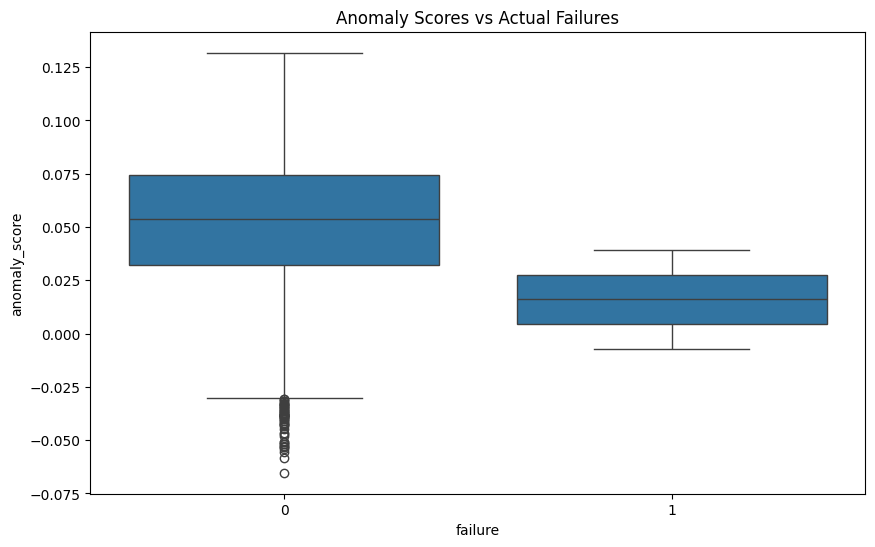

In [ ]:
# Plot anomaly scores
plt.figure(figsize=(10, 6))
sns.boxplot(x='failure', y='anomaly_score', data=processed_data)
plt.title('Anomaly Scores vs Actual Failures')
plt.show()

In [ ]:
"""
## Deployment Strategy
"""
# Save models for deployment
import joblib

# Save predictive maintenance model
joblib.dump(xgb_model, 'predictive_maintenance_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

# Save cost optimization model
joblib.dump(cost_model, 'cost_optimization_model.pkl')
joblib.dump(cost_scaler, 'cost_scaler.pkl')

# Save anomaly detection model
joblib.dump(iso_forest, 'anomaly_detection_model.pkl')

print("Models saved successfully for deployment")

# %% [markdown]


Models saved successfully for deployment


In [ ]:
def simulate_realtime_predictions(model, scaler, num_samples=10, max_attempts=5):
    attempts = 0
    results = None

    while attempts < max_attempts:
        # Generate more samples each attempt to ensure we get enough
        generate_samples = num_samples * (attempts + 1)
        new_data = generate_synthetic_data(generate_samples)

        # Preprocess - ensure we create all required features
        new_data['timestamp'] = pd.to_datetime(new_data['timestamp'])
        new_data['hour'] = new_data['timestamp'].dt.hour
        new_data['is_business_hours'] = ((new_data['hour'] >= 9) & (new_data['hour'] <= 17)).astype(int)
        new_data['day_of_week'] = new_data['timestamp'].dt.dayofweek
        new_data['is_weekend'] = (new_data['day_of_week'] >= 5).astype(int)

        # Create lag features
        for lag in [1, 2, 3]:
            new_data[f'cpu_lag_{lag}'] = new_data.groupby('server_id')['cpu_usage'].shift(lag)
            new_data[f'memory_lag_{lag}'] = new_data.groupby('server_id')['memory_usage'].shift(lag)

        # Create rolling average
        new_data['cpu_rolling_avg_3'] = new_data.groupby('server_id')['cpu_usage'].transform(
            lambda x: x.rolling(3, min_periods=1).mean()
        )

        # Drop NA and get complete cases
        new_data = new_data.dropna()

        # If we have enough samples, process them
        if len(new_data) >= num_samples:
            new_data = new_data.tail(num_samples)
            X_new = new_data[features]
            X_new_scaled = scaler.transform(X_new)

            predictions = model.predict(X_new_scaled)
            probabilities = model.predict_proba(X_new_scaled)[:, 1]

            results = pd.DataFrame({
                'timestamp': new_data['timestamp'],
                'server_id': new_data['server_id'],
                'cpu_usage': new_data['cpu_usage'],
                'memory_usage': new_data['memory_usage'],
                'failure_prediction': predictions,
                'failure_probability': probabilities,
                'recommendation': new_data.apply(recommend_optimization, axis=1)
            })
            break

        attempts += 1

    if results is None:
        raise RuntimeError(f"Failed to generate {num_samples} complete samples after {max_attempts} attempts")

    return results

# Run the simulation with error handling
try:
    if all(obj in globals() for obj in ['xgb_model', 'scaler', 'features']):
        realtime_results = simulate_realtime_predictions(xgb_model, scaler)
        print("\nReal-time Prediction Simulation Results:")
        print(realtime_results.to_string())
    else:
        print("Required objects not found. Please run model training cells first.")
except Exception as e:
    print(f"Simulation failed: {str(e)}")
    print("Possible solutions:")
    print("1. Run all previous cells in order")
    print("2. Check if all required features exist in your data")
    print("3. Increase max_attempts parameter if needed")


Real-time Prediction Simulation Results:
             timestamp server_id  cpu_usage  memory_usage  failure_prediction  failure_probability                                                                                    recommendation
30 2023-01-01 02:30:00  server_0  58.603588     66.334686                   0             0.000079                                                             Current configuration appears optimal
31 2023-01-01 02:35:00  server_1  23.641930     31.922941                   0             0.000079                                                                      Reduce CPU allocation by 30%
32 2023-01-01 02:40:00  server_2  15.204127     20.331327                   0             0.000079        Reduce CPU allocation by 30%; Reduce memory allocation by 30%; Add additional disk storage
33 2023-01-01 02:45:00  server_3  85.910843     68.927686                   0             0.000294  Increase CPU allocation by 30%; Add additional disk storage; Check coo